In [82]:
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline
#os.chdir('./CutMix')
import math
def tensors_as_images(
    tensors, nrows=1, figsize=(8, 8), titles=[], wspace=0.1, hspace=0.2, cmap=None
):
    """
    Plots a sequence of pytorch tensors as images.
    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize,
        gridspec_kw=dict(wspace=wspace, hspace=hspace),
        subplot_kw=dict(yticks=[], xticks=[]),
    )
    if type(axes) is np.ndarray:
        axes_flat = axes.reshape(-1)
    else:
        axes_flat =np.array(axes)
        axes_flat = axes_flat.reshape(-1)

        
    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image - min) / (max - min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis("off")

    return fig, axes

def load_sample_data(loader, batch_size):
    ds = loader.dataset
    input = torch.zeros([batch_size,3,32,32])
    target = torch.zeros([batch_size])
    for i in range(batch_size):
        inp,tar = ds[i]
        input[i,:,:,:] = inp
        target[i] = tar
    return input, target



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import resnet as RN
resnet_cutmix_path = '/home/raz.adi/advanced-dl-final-project/CutMix/runs/my_test_3'
model_name = 'model_best.pth.tar'
ckp_name = 'checkpoint.pth.tar'

model_path = os.path.join(resnet_cutmix_path,model_name)
ckp_path = os.path.join(resnet_cutmix_path,ckp_name)
class args:
    dataset='cifar100'
    depth = 18
    bottleneck = True
    beta = 0
    batch_size = 64
    workers = 4

numberofclass = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model= RN.ResNet(args.dataset, args.depth, numberofclass, args.bottleneck)  # for ResNet
model = torch.nn.DataParallel(model).to(device)
checkpoint = torch.load(ckp_path)
model.load_state_dict(checkpoint['state_dict'])


True


<All keys matched successfully>

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import resnet as RN
import pyramidnet as PYRM
import utils
import numpy as np



normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                         std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

transform_test = transforms.Compose([
transforms.ToTensor(),
normalize
])


val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('../data', train=False, transform=transform_test),
    batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)

from train import validate

criterion = nn.CrossEntropyLoss().cuda()

err1, err5, val_loss = validate(val_loader,model,criterion,900)


In [4]:
val_loss

3.700197009277344

In [12]:

resnet_cutmix_path = '/home/raz.adi/advanced-dl-final-project/CutMix/runs/CutMix'
model_name = 'model_best.pth.tar'
ckp_name = 'checkpoint.pth.tar'

model_path = os.path.join(resnet_cutmix_path,model_name)
ckp_path = os.path.join(resnet_cutmix_path,ckp_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model= RN.ResNet(args.dataset, args.depth, numberofclass, args.bottleneck)  # for ResNet
model = torch.nn.DataParallel(model).to(device)
checkpoint = torch.load(ckp_path)
model.load_state_dict(checkpoint['state_dict'])

class args:
    dataset='cifar100'
    depth = 18
    bottleneck = True
    beta = 0

numberofclass = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RN.ResNet(args.dataset, args.depth, numberofclass, args.bottleneck)  # for ResNet
model = torch.nn.DataParallel(model).to(device)


True
True


### Test corrupted

In [211]:
from dataset import CIFAR100C
from torch.utils.data import Subset, ConcatDataset
from torch.utils.data import random_split

path = '/home/raz.adi/advanced-dl-final-project/CutMix/runs/my_test_3'
model_name = 'model_best.pth.tar'
ckp_name = 'checkpoint.pth.tar'

model_path = os.path.join(path,model_name)
ckp_path = os.path.join(path,ckp_name)

model= RN.ResNet(args.dataset, args.depth, numberofclass, args.bottleneck)  # for ResNet
model = torch.nn.DataParallel(model).to(device)
checkpoint = torch.load(ckp_path)
model.load_state_dict(checkpoint['state_dict'])

class args:
    dataset='cifar100'
    depth = 18
    bottleneck = True
    beta = 0
    batch_size = 64
    workers = 4


my_data_root = '../data'
def load_txt(path :str) -> list:
    return [line.rstrip('\n') for line in open(path)]

corruptions = load_txt('./corruptions.txt')

for i, cname in enumerate(corruptions):
    tmp_dataset = CIFAR100C(root=os.path.join(my_data_root, 'CIFAR-100-C'),name=cname,
                                transform=transform_test)

    start= 20000
    stop = 30000
    indices = [i for i in range(start, stop)] # use sevirity 3
    sev3 = Subset(tmp_dataset, indices)
    split_lengths = [int(len(sev3)*0.833), int(len(sev3)*0.167)]
    _ , sev3_testset = random_split(sev3, split_lengths) 
    if i==0:
        testset_arr = [sev3_testset]
    else:
        testset_arr.append(sev3_testset)

valset =  ConcatDataset(testset_arr)

val_loader = torch.utils.data.DataLoader(
    valset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True, drop_last=True)
numberofclass = 100




True


In [212]:
input, target = load_sample_data(val_loader,64)
err1, err5, val_loss = validate(val_loader,model,criterion,300)
print(err1,err5,val_loss)


72.37580128205128 45.67307692307692 3.1893832500164327


(<Figure size 576x576 with 5 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

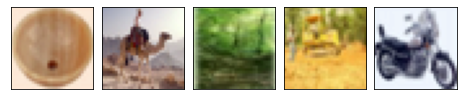

In [79]:
tensors_as_images(input[0:5])

In [69]:
target[0:5]

tensor([73., 68., 34., 73., 45.])

In [27]:
from matplotlib import pyplot as plt
len(valset[0])

2

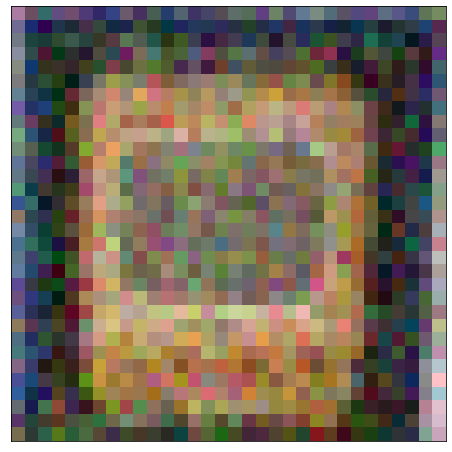

3

## where the model goes wrong?

In [213]:
import torch
import resnet as RN
resnet_cutmix_path = '/home/raz.adi/advanced-dl-final-project/CutMix/runs/my_test_3'
model_name = 'model_best.pth.tar'
ckp_name = 'checkpoint.pth.tar'

model_path = os.path.join(resnet_cutmix_path,model_name)
ckp_path = os.path.join(resnet_cutmix_path,ckp_name)
class args:
    dataset='cifar100'
    depth = 18
    bottleneck = True
    beta = 0
    batch_size = 64
    workers = 4

numberofclass = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model= RN.ResNet(args.dataset, args.depth, numberofclass, args.bottleneck)  # for ResNet
model = torch.nn.DataParallel(model).to(device)
checkpoint = torch.load(ckp_path)
model.load_state_dict(checkpoint['state_dict'])


True


<All keys matched successfully>

In [214]:
input, target = load_sample_data(val_loader,64)


In [215]:
from matplotlib import pyplot as plt

normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                         std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

transform_test = transforms.Compose([
transforms.ToTensor(),
normalize
])

ds = datasets.CIFAR100('../data', train=False, transform=transform_test)

val_loader = torch.utils.data.DataLoader(ds,
    batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)

from train import validate

criterion = nn.CrossEntropyLoss().cuda()

err1, err5, val_loss = validate(val_loader,model,criterion,900)


,gt,true class,output,output class
0,17,castle,18,caterpillar
1,84,table,24,cockroach
2,32,flatfish,1,aquarium_fish
3,80,squirrel,18,caterpillar
4,79,spider,1,aquarium_fish
5,2,baby,54,orchid
6,28,cup,61,plate
7,85,tank,10,bowl
8,37,house,0,apple
9,39,keyboard,54,orchid


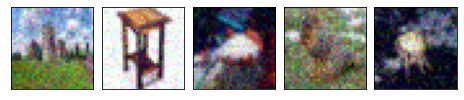

In [216]:
model_output = model(input)

max_out ,ind = torch.max(model_output,1)
device = 'cuda'

false = torch.where(ind.to(device)!=target.to(device))[0].data.cpu().numpy()

tensors_as_images(input[false][0:5])

import pandas as pd
import numpy as np

target_ = np.int8(target.data.cpu().numpy())
output_ = np.int8(ind.data.cpu().numpy())



classes = np.array(ds.classes)
true_class = classes[target_]
out_class = classes[output_]

data = {'gt':  target_[false],
        'true class': true_class[false],
        'output':output_[false],
        'output class': out_class[false]
        }

df = pd.DataFrame(data)
pd.set_option('display.max_rows', df.shape[0]+1)
df.style



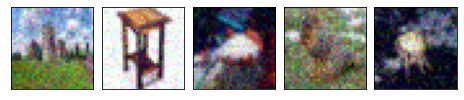

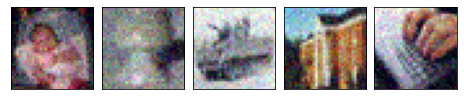

In [217]:

fig , ax = tensors_as_images(input[false][0:5])

fig , ax =tensors_as_images(input[false][5:10])

In [138]:
classes

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,